# Notebook to explore the naming of the class names for FoodVision

* **Goal:** Get the class names for FoodVision and see which ones can be broken down into something more specific.

* If I want to change a class name to be broken down into different subclasses, I can rename them with OpenCLIP (fast)
* For example, go through all images/labels that contain "lettuce" and use OpenCLIP to rename them to varations such as ("lettuce_oakleaf", "lettuce_iceberg", "lettuce_cos" etc)
    * Could exclude all images that contain the `label_source` as "manual_upload" (these are ground truth style images)


In [1]:
# Append the upper level directory to sys
import sys
sys.path.append("..")

import pandas as pd
import numpy as np

from pathlib import Path

import torch

from utils.misc import sort_dict_by_values

from zero_shot_classification import open_clip_compute_image_features_of_list, open_clip_compute_text_features, open_clip_zero_shot_classification


/home/daniel/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/daniel/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowIlEET_S2_S2_b
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Get original labels to label new data from
# Get config
from configs.default_config import config

args = config

# Connect to GCP
from utils.gcp_utils import set_gcp_credentials, test_gcp_connection
set_gcp_credentials(path_to_key="../utils/google-storage-key.json")
test_gcp_connection()

import wandb

# Initialize a new run
from utils.wandb_utils import wandb_load_artifact, wandb_download_and_load_labels

notes = f"autorelabel existing images into subclasses, e.g. 'lettuce' -> 'lettuce_cos', 'lettuce_iceberg' etc"

run = wandb.init(project=args.wandb_project, 
                 job_type=args.wandb_job_type,
                 tags=['auto_label_new_images'],
                 notes=notes)

annotations, class_names, class_dict, reverse_class_dict, labels_path = wandb_download_and_load_labels(wandb_run=run,
wandb_labels_artifact_name=args.wandb_labels_artifact)

len(annotations.label.unique())

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] GCP credentials set!
[INFO] GCP connection successful! Access to GCP for saving/loading data and models available.


wandb: Currently logged in as: mrdbourke. Use `wandb login --relogin` to force relogin


[INFO] Labels directory: ./artifacts/food_vision_labels:v44
[INFO] Labels path: artifacts/food_vision_labels:v44/annotations.csv
[INFO] Working with: 268 classes


268

In [3]:
annotations, class_names, class_dict, reverse_class_dict, labels_path = wandb_download_and_load_labels(wandb_run=run,
wandb_labels_artifact_name=args.wandb_labels_artifact)

[INFO] Labels directory: ./artifacts/food_vision_labels:v44
[INFO] Labels path: artifacts/food_vision_labels:v44/annotations.csv
[INFO] Working with: 268 classes


In [4]:
annotations_value_counts_dict = annotations.class_name.value_counts().to_dict()
# Sort the annotations_dict in alphabetical order by key
annotations_value_counts_dict = {k: v for k, v in sorted(annotations_value_counts_dict.items(), key=lambda item: item[0])}
annotations_value_counts_dict

{'almond_butter': 185,
 'almonds': 1022,
 'apple_green': 659,
 'apple_red': 1321,
 'apricot': 847,
 'artichoke': 936,
 'asparagus': 1003,
 'avocado': 1008,
 'bacon': 145,
 'bacon_and_egg_burger': 202,
 'bagel': 131,
 'baklava': 172,
 'banana': 1562,
 'banana_bread': 220,
 'barbecue_sauce': 198,
 'basil': 675,
 'bean_sprouts': 1015,
 'beans': 101,
 'beef_curry': 205,
 'beef_diced': 1,
 'beef_kebab': 7,
 'beef_mince': 192,
 'beef_patty': 9,
 'beef_roast': 194,
 'beef_stir_fry': 213,
 'beer': 192,
 'beetroot': 560,
 'biltong': 191,
 'blackberries': 202,
 'blueberries': 784,
 'bok_choy': 1019,
 'bread': 264,
 'bread_naan': 73,
 'broccoli': 576,
 'broccolini': 353,
 'brownie': 184,
 'brussel_sprouts': 803,
 'burrito': 174,
 'butter': 129,
 'cabbage_green': 84,
 'cabbage_red': 491,
 'calamari': 194,
 'candy': 182,
 'capsicum_green': 287,
 'capsicum_orange': 240,
 'capsicum_red': 240,
 'capsicum_yellow': 275,
 'carrot': 1094,
 'carrot_purple': 2,
 'cashews': 1002,
 'cauliflower': 716,
 'celer

In [5]:
len(class_dict), len(class_names), len(reverse_class_dict)

(268, 268, 268)

In [51]:
# Find the class_names with "lettuce" in them
[class_name for class_name in class_names if "melon" in class_name]

['honeydew_melon',
 'melon_candy',
 'melon_dino',
 'melon_spanish',
 'rockmelon',
 'watermelon']

In [7]:
# Download dataset artifact
from utils.wandb_utils import wandb_load_artifact
images_dir = wandb_load_artifact(
    wandb_run=run,
    artifact_name=args.wandb_dataset_artifact,
    artifact_type="dataset")
print(f"[INFO] Dataset artifact loaded from: {images_dir}")

wandb: Downloading large artifact food_vision_199_classes_images:latest, 16951.65MB. 118008 files... Done. 0:0:23.3


[INFO] Dataset artifact loaded from: ./artifacts/food_vision_199_classes_images:v17


In [8]:
# Multi names:
# onion_green -> spring_onion, bunching_onion
# shallots -> shallot, eschalot (also called eschallot), french shallot, scallion
# soda -> soft drink

# For VegFru
# "globe_artichoke" in VegFru is the same as "artichoke" in Harris Farm
# "chicory" in VegFru is the same as "chicory" in Harris Farm

## Update annotations

In [9]:
original_annotations = annotations.copy()
updated_annotations = original_annotations.copy()

In [26]:
target_class_name_to_update = ["squash"] # e.g. all classes containing lettuce
target_class_name_update_options = ["squash_butternut", "squash_pattypan", "pumpkin"] # e.g. rename the target class to one of these 

# Get all rows in original annotations with target_class_name_to_update as "class_name"
# target_class_name_to_update_rows = updated_annotations[updated_annotations.class_name == "mushrooms"]
target_class_name_to_update_rows = updated_annotations[updated_annotations.class_name.str.contains(target_class_name_to_update[0])]

# Exclude rows where label_source = "manual_upload"
exclude_manual = False
if exclude_manual:
    target_class_name_to_update_rows = target_class_name_to_update_rows[target_class_name_to_update_rows.label_source != "manual_upload"]

print(f"Number of rows to update: {len(target_class_name_to_update_rows)}")
target_class_name_to_update_rows.head()

Number of rows to update: 178


,filename,image_name,class_name,label,split,clear_or_confusing,whole_food_or_dish,one_food_or_multiple,label_last_updated_at,label_source,image_source
3005,test/squash/eac8a7a0-7c43-498a-8fc8-e1f0df9028...,eac8a7a0-7c43-498a-8fc8-e1f0df902806.jpg,squash,240,test,NaN,NaN,NaN,NaN,NaN,internet_download
3006,test/squash/35aaacb3-6500-41a1-a6c7-b612da27b3...,35aaacb3-6500-41a1-a6c7-b612da27b34a.jpg,squash,240,test,NaN,NaN,NaN,NaN,NaN,internet_download
3008,test/squash/e0afe479-6e33-4d95-a09e-f036a15bf4...,e0afe479-6e33-4d95-a09e-f036a15bf4e1.jpg,squash,240,test,NaN,NaN,NaN,NaN,NaN,internet_download
3009,test/squash/038f8459-090c-43f3-92d4-412e5b2ad5...,038f8459-090c-43f3-92d4-412e5b2ad555.jpg,squash,240,test,NaN,NaN,NaN,NaN,NaN,internet_download
3010,test/squash/8fc3f9c7-29be-46c3-9c92-b9b2bb04e5...,8fc3f9c7-29be-46c3-9c92-b9b2bb04e5a5.jpg,squash,240,test,NaN,NaN,NaN,NaN,NaN,internet_download


In [27]:
target_class_name_to_update_rows.label_source.value_counts()

clip_retrieval_laion_5b_knn          60
manual_upload                         3
auto_labelled_clip_and_blip_match     2
Name: label_source, dtype: int64

In [28]:
# Get a list of all images in the dataset
import os
image_paths = os.listdir(images_dir)
len(image_paths)

118008

In [29]:
# Get a list of image_names to update
image_names_to_update = target_class_name_to_update_rows.image_name.unique()
len(image_names_to_update)

178

In [30]:
images_dir

'./artifacts/food_vision_199_classes_images:v17'

In [31]:
# Create image paths to update
image_paths_to_update = [Path(images_dir, image_path) for image_path in image_paths if image_path in image_names_to_update]
len(image_paths_to_update), image_paths_to_update[:10]

(178,
 [PosixPath('artifacts/food_vision_199_classes_images:v17/24a3d8fe-fe19-4b47-8d88-547568f9badb.jpg'),
  PosixPath('artifacts/food_vision_199_classes_images:v17/52bed01f-09bf-42a3-b58b-b206c5a99949.jpg'),
  PosixPath('artifacts/food_vision_199_classes_images:v17/1de41abb-87ed-43ea-b7c7-383e3ba2125e.jpg'),
  PosixPath('artifacts/food_vision_199_classes_images:v17/042f4162-8042-4324-9aee-2a1d6e1b5a55.jpg'),
  PosixPath('artifacts/food_vision_199_classes_images:v17/9d42478e-71cb-44dc-808f-5743b10c8f1f.jpg'),
  PosixPath('artifacts/food_vision_199_classes_images:v17/a372664e-0249-44eb-be8f-aba69c484691.jpg'),
  PosixPath('artifacts/food_vision_199_classes_images:v17/623c899d-d535-4c05-97a9-ec14ff479ee8.jpg'),
  PosixPath('artifacts/food_vision_199_classes_images:v17/ec04f96b-b342-483a-8505-92cc3ce13e28.jpg'),
  PosixPath('artifacts/food_vision_199_classes_images:v17/51e82d84-72f3-4db2-8271-4b6ea96288cb.jpg'),
  PosixPath('artifacts/food_vision_199_classes_images:v17/eac8a7a0-7c43-498a

In [16]:
# Compute CLIP embeddings for images in image_paths_to_update
open_clip_image_features_list = open_clip_compute_image_features_of_list(
    image_paths=image_paths_to_update,
)

Computing OpenCLIP image features:   0%|          | 0/178 [00:00<?, ?it/s]

In [32]:
from typing import List
from tqdm.auto import tqdm

def open_clip_get_image_and_text_similarity_dicts(open_clip_image_features_list: list,
                                                  target_classes: List[str],
                                                  max_len_of_similarity_dict: int = 10):
    
    # Set CLIP and BLIP to use GPU for creating image features if available
    # img_feature_device = "cuda" if torch.cuda.is_available() else "cpu"

    # Encode text features on CPU (this is quick even for 100s of classes)
    # blip_text_features = blip_get_text_features(text=target_classes, device="cpu") # only get dims for zero-shot classification
    open_clip_text_features = open_clip_compute_text_features(text=target_classes)
    
    # Loop through image paths
    auto_created_labels = []
    for image_feature_dict in tqdm(open_clip_image_features_list, desc="Calculating image features and similarity dicts"):

        image_path = image_feature_dict["image_path"]
        # Match image path to pre-computed image features
        # print(image_paths.index(image_path))
        open_clip_img_features = image_feature_dict["image_features"]
        # blip_img_features = blip_image_features_list[image_paths.index(image_path)]["image_features"][:, 0] # TODO: could the indexing be cleaner?
        
        # Get sorted similarity dicts
        open_clip_similarity_dict = open_clip_zero_shot_classification(open_clip_img_features, open_clip_text_features, target_classes, sorted=True)
        # blip_similarity_dict = blip_zero_shot_classification(blip_img_features, blip_text_features, target_classes, sorted=True)

        # # Average the values of the similarity dicts
        # avg_similarity_dict = {}
        # for key in open_clip_similarity_dict.keys():
        #     avg_similarity_dict[key] = (open_clip_similarity_dict[key] + blip_similarity_dict[key]) / 2
        
        # # Sort the average similarity dict and reduce length to 5
        # avg_similarity_dict = dict(list(sort_dict_by_values(avg_similarity_dict).items())[:5])

        # If the length of the similarity dicts is max_len_of_similarity_dict, shorten it
        if len(open_clip_similarity_dict) > max_len_of_similarity_dict:
            open_clip_similarity_dict = dict(list(open_clip_similarity_dict.items())[:max_len_of_similarity_dict])
        
        # if len(blip_similarity_dict) > 5:
        #     blip_similarity_dict = dict(list(blip_similarity_dict.items())[:5])
        
        # Append to list
        auto_created_labels.append({"image_path": image_path,
                                    "image_name": image_path.name,
                                    # "blip_sorted_similarity_dict": blip_similarity_dict,
                                    # "blip_top_1_class_name": list(blip_similarity_dict.keys())[0],
                                    # "blip_top_1_similarity_score": list(blip_similarity_dict.values())[0],
                                    "open_clip_sorted_similarity_dict": open_clip_similarity_dict,
                                    "open_clip_top_1_class_name": list(open_clip_similarity_dict.keys())[0],
                                    "open_clip_top_1_similarity_score": list(open_clip_similarity_dict.values())[0],
                                    # "avg_sorted_similarity_dict": avg_similarity_dict,
                                    # "avg_top_1_class_name": list(avg_similarity_dict.keys())[0],
                                    # "avg_top_1_similarity_score": list(avg_similarity_dict.values())[0]
                                })
    
    return auto_created_labels

In [33]:
# Get similarity dicts
image_and_text_similarity_dicts = open_clip_get_image_and_text_similarity_dicts(open_clip_image_features_list=open_clip_image_features_list,
                                                                                target_classes=target_class_name_update_options)

Calculating image features and similarity dicts:   0%|          | 0/178 [00:00<?, ?it/s]

In [34]:
# Turn the similarity dicts into a dataframe
import pandas as pd
image_and_text_similarity_df = pd.DataFrame(image_and_text_similarity_dicts)
image_and_text_similarity_df

,image_path,image_name,open_clip_sorted_similarity_dict,open_clip_top_1_class_name,open_clip_top_1_similarity_score
0,artifacts/food_vision_199_classes_images:v17/2...,24a3d8fe-fe19-4b47-8d88-547568f9badb.jpg,"{'squash_pattypan': 0.5521239042282104, 'squas...",squash_pattypan,0.552124
1,artifacts/food_vision_199_classes_images:v17/5...,52bed01f-09bf-42a3-b58b-b206c5a99949.jpg,"{'squash_butternut': 0.9849244952201843, 'squa...",squash_butternut,0.984924
2,artifacts/food_vision_199_classes_images:v17/1...,1de41abb-87ed-43ea-b7c7-383e3ba2125e.jpg,"{'squash_pattypan': 0.9661622643470764, 'squas...",squash_pattypan,0.966162
3,artifacts/food_vision_199_classes_images:v17/0...,042f4162-8042-4324-9aee-2a1d6e1b5a55.jpg,"{'squash_pattypan': 0.9951695799827576, 'squas...",squash_pattypan,0.995170
4,artifacts/food_vision_199_classes_images:v17/9...,9d42478e-71cb-44dc-808f-5743b10c8f1f.jpg,"{'squash_pattypan': 0.9376106262207031, 'pumpk...",squash_pattypan,0.937611
...,...,...,...,...,...
173,artifacts/food_vision_199_classes_images:v17/5...,5f048050-35ac-4c4b-bc98-0d9c27072c8d.jpg,"{'squash_pattypan': 0.6535110473632812, 'squas...",squash_pattypan,0.653511
174,artifacts/food_vision_199_classes_images:v17/a...,afc642e0-221b-49e4-8b23-9b6d56726964.jpg,"{'squash_butternut': 0.9944655299186707, 'squa...",squash_butternut,0.994466
175,artifacts/food_vision_199_classes_images:v17/8...,8f1fa518-ac22-4f51-a338-0dc5373fa325.jpg,"{'squash_butternut': 0.9925534129142761, 'squa...",squash_butternut,0.992553
176,artifacts/food_vision_199_classes_images:v17/8...,8ca52ac0-69db-487b-bda0-91174579487f.jpg,"{'squash_pattypan': 0.9990597367286682, 'squas...",squash_pattypan,0.999060


In [35]:
image_and_text_similarity_df.open_clip_top_1_class_name.value_counts()

squash_butternut    90
squash_pattypan     81
pumpkin              7
Name: open_clip_top_1_class_name, dtype: int64

In [36]:
# How many images have a score over 0.9?
use_threshold = False
threshold = 0.9

if use_threshold:
    over_threshold = image_and_text_similarity_df[image_and_text_similarity_df.open_clip_top_1_similarity_score > threshold]
else:
    over_threshold = image_and_text_similarity_df[image_and_text_similarity_df.open_clip_top_1_similarity_score > 0]
len(over_threshold)

178

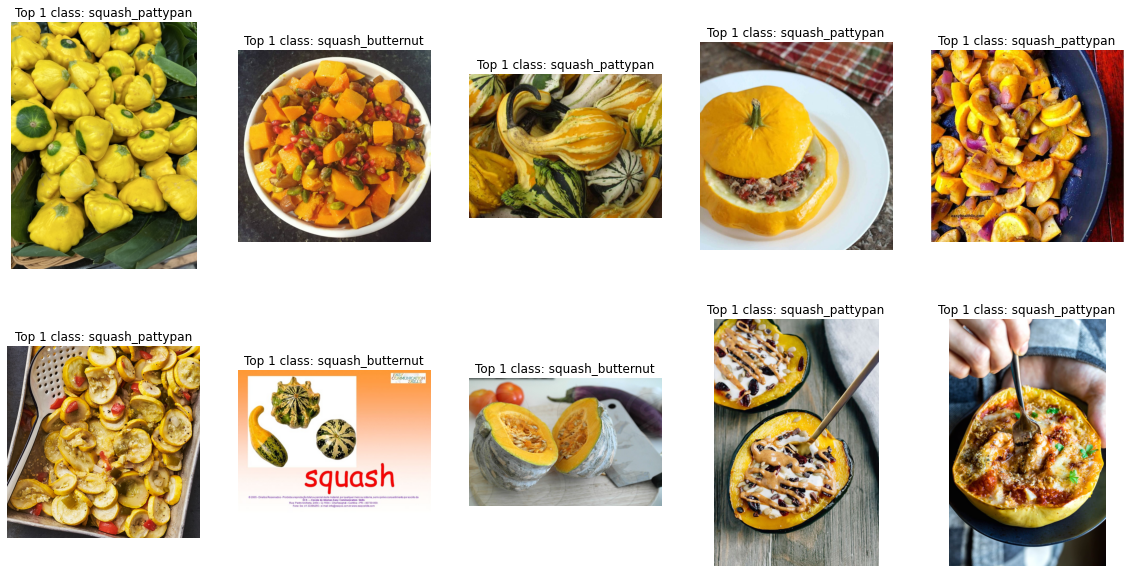

In [40]:
# Plot 10 random images with their top 1 class_name
import matplotlib.pyplot as plt

def plot_10_random_images_from_df(df, image_path_col="image_name", title_col=None):
    fig, ax = plt.subplots(2, 5, figsize=(20, 10))
    for i, row in enumerate(df.sample(10).iterrows()):
        row = row[1]
        # print(i)
        ax[i // 5, i % 5].imshow(plt.imread(row["image_path"]))
        ax[i // 5, i % 5].set_title(f"Top 1 class: {row[title_col]}")
        ax[i // 5, i % 5].axis(False)

plot_10_random_images_from_df(df=over_threshold, image_path_col="image_path", title_col="open_clip_top_1_class_name")
    # ax[i // 5, i % 5].set_yticks([])

In [41]:
# Take over_90 dataframe
# Find the top 1 class_name for each image
# Change the "class_name" value in updated_annotations for matching image_name

from utils.misc import get_now_time

# Rename "open_clip_top_1_class_name" to "class_name" in over_90
over_threshold.rename(columns={"open_clip_top_1_class_name": "class_name"}, inplace=True)
over_threshold_filtered = over_threshold[["image_name", "class_name"]].copy().set_index("image_name")
over_threshold_filtered["label_source"] = "open_clip_auto_relabel"
over_threshold_filtered["label_last_updated_at"] = get_now_time()
over_threshold_filtered.head()


,class_name,label_source,label_last_updated_at
image_name,,,
24a3d8fe-fe19-4b47-8d88-547568f9badb.jpg,squash_pattypan,open_clip_auto_relabel,2023-03-13_09-41-26
52bed01f-09bf-42a3-b58b-b206c5a99949.jpg,squash_butternut,open_clip_auto_relabel,2023-03-13_09-41-26
1de41abb-87ed-43ea-b7c7-383e3ba2125e.jpg,squash_pattypan,open_clip_auto_relabel,2023-03-13_09-41-26
042f4162-8042-4324-9aee-2a1d6e1b5a55.jpg,squash_pattypan,open_clip_auto_relabel,2023-03-13_09-41-26
9d42478e-71cb-44dc-808f-5743b10c8f1f.jpg,squash_pattypan,open_clip_auto_relabel,2023-03-13_09-41-26


In [42]:
updated_annotations = original_annotations.copy()

In [43]:
updated_annotations = updated_annotations.set_index("image_name")
updated_annotations.update(over_threshold_filtered)
# updated_annotations.reset_index(inplace=True)

In [44]:
updated_annotations = updated_annotations.reset_index()
updated_annotations.head()

,image_name,filename,class_name,label,split,clear_or_confusing,whole_food_or_dish,one_food_or_multiple,label_last_updated_at,label_source,image_source
0,4fd7cb42-bd7f-48f1-bfdc-607c2f54b788.jpg,test/pain_au_chocolat/4fd7cb42-bd7f-48f1-bfdc-...,pain_au_chocolat,164,test,NaN,NaN,NaN,NaN,NaN,internet_download
1,2062f52a-781c-4e4f-b8a7-0a108934f453.jpg,test/pain_au_chocolat/2062f52a-781c-4e4f-b8a7-...,pain_au_chocolat,164,test,NaN,NaN,NaN,NaN,NaN,internet_download
2,8003e0f6-37e8-460d-9c14-e7c6fe44a37f.jpg,test/pain_au_chocolat/8003e0f6-37e8-460d-9c14-...,pain_au_chocolat,164,test,NaN,NaN,NaN,NaN,NaN,internet_download
3,839437c8-c643-408f-9f04-d0d3bec238c3.jpg,test/pain_au_chocolat/839437c8-c643-408f-9f04-...,pain_au_chocolat,164,test,NaN,NaN,NaN,NaN,NaN,internet_download
4,ca5c13ff-a535-4b69-9144-e06275e01e35.jpg,test/pain_au_chocolat/ca5c13ff-a535-4b69-9144-...,pain_au_chocolat,164,test,NaN,NaN,NaN,NaN,NaN,internet_download


In [45]:
from typing import List, Dict, Tuple

def get_updated_class_names_class_dict_and_reverse_class_dict(df: pd.DataFrame) -> Tuple[List[str], Dict[int, str], Dict[str, int]]:
    """Get an updated class names list, class dict and reverse class dict from a dataframe."""
    updated_class_names = sorted(df.class_name.unique())
    updated_class_dict = {i: class_name for i, class_name in enumerate(updated_class_names)}
    updated_reverse_class_dict = {class_name: i for i, class_name in enumerate(updated_class_names)}
    assert len(updated_class_dict) == len(updated_reverse_class_dict), "Class dict and reverse class dict are not the same length"
    return updated_class_names, updated_class_dict, updated_reverse_class_dict

def map_updated_class_dict_to_updated_annotations(df: pd.DataFrame, updated_reverse_class_dict: Dict[str, int]) -> pd.DataFrame:
    """Map updated class dict to updated annotations dataframe.
    
    For example, go from {"apple_red": 1} -> df["label"] = 1
    """
    updated_annotations = df.copy()
    updated_annotations.loc[:, 'label'] = updated_annotations['class_name'].map(updated_reverse_class_dict)
    assert len(updated_annotations.label.unique()) == len(updated_reverse_class_dict), "Number of unique labels in updated annotations does not match number of unique class names in updated reverse class dict"
    return updated_annotations

In [46]:
updated_class_names, updated_class_dict, updated_reverse_class_dict = get_updated_class_names_class_dict_and_reverse_class_dict(updated_annotations)

updated_annotations = map_updated_class_dict_to_updated_annotations(updated_annotations, updated_reverse_class_dict)

len(updated_class_names), updated_class_names[:10]

(269,
 ['almond_butter',
  'almonds',
  'apple_green',
  'apple_red',
  'apricot',
  'artichoke',
  'asparagus',
  'avocado',
  'bacon',
  'bacon_and_egg_burger'])

In [47]:
updated_class_names

['almond_butter',
 'almonds',
 'apple_green',
 'apple_red',
 'apricot',
 'artichoke',
 'asparagus',
 'avocado',
 'bacon',
 'bacon_and_egg_burger',
 'bagel',
 'baklava',
 'banana',
 'banana_bread',
 'barbecue_sauce',
 'basil',
 'bean_sprouts',
 'beans',
 'beef_curry',
 'beef_diced',
 'beef_kebab',
 'beef_mince',
 'beef_patty',
 'beef_roast',
 'beef_stir_fry',
 'beer',
 'beetroot',
 'biltong',
 'blackberries',
 'blueberries',
 'bok_choy',
 'bread',
 'bread_naan',
 'broccoli',
 'broccolini',
 'brownie',
 'brussel_sprouts',
 'burrito',
 'butter',
 'cabbage_green',
 'cabbage_red',
 'calamari',
 'candy',
 'capsicum_green',
 'capsicum_orange',
 'capsicum_red',
 'capsicum_yellow',
 'carrot',
 'carrot_purple',
 'cashews',
 'cauliflower',
 'celery',
 'cheese',
 'cheeseburger',
 'cherries',
 'chicken_breast',
 'chicken_thighs',
 'chicken_wings',
 'chicory',
 'chilli',
 'chimichurri',
 'chives',
 'chocolate',
 'chocolate_cake',
 'choko',
 'coconut',
 'coffee',
 'coleslaw',
 'cookies',
 'coriander'

In [48]:
from utils.misc import check_for_differences_between_df

num_differences = check_for_differences_between_df(updated_annotations, original_annotations)
num_differences

11246

In [49]:
updated_annotations.class_name.value_counts().to_dict()

{'grapes_red': 1830,
 'papaya': 1817,
 'eggplant': 1815,
 'garlic': 1713,
 'mango': 1642,
 'banana': 1562,
 'strawberries': 1556,
 'cherries': 1496,
 'pecans': 1397,
 'passionfruit': 1391,
 'grapes_white': 1352,
 'pomegranate': 1331,
 'apple_red': 1321,
 'kiwi_fruit': 1299,
 'figs': 1293,
 'watermelon': 1277,
 'guava': 1259,
 'nectarine': 1249,
 'peas': 1241,
 'lychee': 1236,
 'potato_sweet': 1230,
 'grapes_black': 1218,
 'corn': 1208,
 'walnuts': 1203,
 'tomato_cherry': 1185,
 'peach': 1181,
 'pineapple': 1141,
 'tomato': 1139,
 'cucumber': 1131,
 'plum': 1112,
 'carrot': 1094,
 'almonds': 1022,
 'bok_choy': 1019,
 'bean_sprouts': 1015,
 'mangosteen': 1011,
 'avocado': 1008,
 'asparagus': 1003,
 'cashews': 1002,
 'chilli': 993,
 'ginger': 981,
 'orange': 978,
 'pistachio': 975,
 'pumpkin': 958,
 'persimmon': 946,
 'longan': 944,
 'artichoke': 936,
 'jerusalem_artichoke': 931,
 'leek': 892,
 'raspberries': 871,
 'rhubarb': 860,
 'apricot': 847,
 'lemon': 823,
 'brussel_sprouts': 803,
 

In [52]:
# Upload the updated annotations to Google Storage and track the changes
import os
from utils.gcp_utils import upload_to_gs, rename_blob, delete_blob
from utils.wandb_utils import wandb_add_artifact_with_reference
from utils.misc import get_now_time

UPDATED_ANNOTATIONS_TARGET_FILENAME = "updated_annotations.csv"
ORIGINAL_ANNOTATIONS_TARGET_FILENAME = "annotations.csv"
GS_BUCKET_NAME = config.gs_bucket_name

# Export the updated annotations to a CSV
columns_to_export = config.annotations_columns_to_export
print(f"[INFO] Exporting the following columns to {UPDATED_ANNOTATIONS_TARGET_FILENAME}: {columns_to_export}")

# TODO: Check if the updated_annotations_reset_index and the original_annotations actually differ, if so save them and upload them, else exit
if num_differences > 0:
    print(f"[INFO] {num_differences} changes to annotations.csv, updated label files and original annotations are different, saving the updated annotations.csv")

    # Export the updated_annotations_reset_index to a csv
    updated_annotations[columns_to_export].to_csv(UPDATED_ANNOTATIONS_TARGET_FILENAME, index=False)

    # Upload the updated CSV to Google Storage
    upload_to_gs(bucket_name=GS_BUCKET_NAME, 
                 source_file_name=UPDATED_ANNOTATIONS_TARGET_FILENAME, 
                 destination_blob_name=UPDATED_ANNOTATIONS_TARGET_FILENAME)

    # Rename the old CSV on Google Storage
    bucket_to_move_old_annotations_to = "old_annotations"
    name_to_rename_old_annotations = os.path.join(bucket_to_move_old_annotations_to, f"{get_now_time()}_old_annotations.csv")

    rename_blob(bucket_name=GS_BUCKET_NAME,
                blob_name=ORIGINAL_ANNOTATIONS_TARGET_FILENAME,
                new_name=name_to_rename_old_annotations)

    # Rename the "updated_annotations.csv" on Google Storage to "annotations.csv" 
    rename_blob(bucket_name=GS_BUCKET_NAME,
                blob_name=UPDATED_ANNOTATIONS_TARGET_FILENAME,
                new_name=ORIGINAL_ANNOTATIONS_TARGET_FILENAME)

    # Track the changes in the annotations with Weights & Biases
    annotations_path_on_gcs = f"gs://{GS_BUCKET_NAME}/{ORIGINAL_ANNOTATIONS_TARGET_FILENAME}"
    wandb_add_artifact_with_reference(wandb_run=run,
                                      artifact_name="food_vision_labels",
                                      artifact_type="labels",
                                      description="Labels for FoodVision project",
                                      reference_path=annotations_path_on_gcs)
else:
    print("[INFO] No changes to annotations.csv, updated label files and original annotations are the same, try fixing/updating the label files and try again")

[INFO] Exporting the following columns to updated_annotations.csv: ['filename', 'image_name', 'class_name', 'label', 'split', 'clear_or_confusing', 'whole_food_or_dish', 'one_food_or_multiple', 'label_last_updated_at', 'label_source', 'image_source']
[INFO] 11246 changes to annotations.csv, updated label files and original annotations are different, saving the updated annotations.csv
[INFO] Uploading updated_annotations.csv to updated_annotations.csv...
[INFO] Connected to Google Storage bucket: food_vision_bucket_with_object_versioning
[INFO] File updated_annotations.csv uploaded to food_vision_bucket_with_object_versioning/updated_annotations.csv.
[INFO] File size: 22220023 bytes
[INFO] Blob annotations.csv has been renamed to old_annotations/2023-03-13_09-52-13_old_annotations.csv
[INFO] Blob updated_annotations.csv has been renamed to annotations.csv
[INFO] Logging 'food_vision_labels' from 'gs://food_vision_bucket_with_object_versioning/annotations.csv' to Weights & Biases...


In [ ]:
# Go through image_names_to_update
# Calculate CLIP embeddings for each image
# Match the CLIP embeddings to the target class name options
# Update the labels with over 0.9 similarity scores

In [71]:
# radish -> radish_red/radish_white (also called daikon_radish)
radish_options = ["radish_red", "radish_white"]

radish_rows = updated_annotations[updated_annotations['class_name'] == "radish"]
radish_indices = radish_rows.index

updated_annotations.loc[radish_indices, 'class_name'] = np.random.choice(radish_options, size=len(radish_indices))

# How many rows contain "radish"?
len(updated_annotations[updated_annotations['class_name'].str.contains("radish")])
updated_annotations[updated_annotations['class_name'].str.contains("radish")]

,filename,image_name,class_name,label,split,clear_or_confusing,whole_food_or_dish,one_food_or_multiple,label_last_updated_at,label_source,image_source
2097,test/daikon_radish/ff48d84c-d20f-4166-a12f-cb1...,ff48d84c-d20f-4166-a12f-cb1158bac3cd.jpg,daikon_radish,64,test,NaN,NaN,NaN,NaN,NaN,internet_download
2098,test/daikon_radish/fbe10a12-5171-4f91-8789-8d8...,fbe10a12-5171-4f91-8789-8d8790a4ad07.jpg,daikon_radish,64,test,NaN,NaN,NaN,NaN,NaN,internet_download
2099,test/daikon_radish/aebe0abd-fe6f-41db-b83d-d26...,aebe0abd-fe6f-41db-b83d-d26fc327a724.jpg,daikon_radish,64,test,NaN,NaN,NaN,NaN,NaN,internet_download
2100,test/daikon_radish/29c636b5-9bfd-4299-8e25-c09...,29c636b5-9bfd-4299-8e25-c09728ee7edf.jpg,daikon_radish,64,test,NaN,NaN,NaN,NaN,NaN,internet_download
2101,test/daikon_radish/2e27848e-858e-45d7-8495-5c8...,2e27848e-858e-45d7-8495-5c8fc91d8e89.jpg,daikon_radish,64,test,NaN,NaN,NaN,NaN,NaN,internet_download
...,...,...,...,...,...,...,...,...,...,...,...
96543,all_nutrify_vegfru/radish_red/9ef1a88c-2282-43...,9ef1a88c-2282-430c-a785-4b53fb2f79bc.jpeg,radish_red,215,train,NaN,NaN,NaN,2023-02-27_14-38-31,vegfru_dataset_with_manual_filtering,vegfru_dataset
96544,all_nutrify_vegfru/radish_red/39777b14-fc09-48...,39777b14-fc09-485f-916d-037270d45586.jpeg,radish_red,215,train,NaN,NaN,NaN,2023-02-27_14-38-31,vegfru_dataset_with_manual_filtering,vegfru_dataset
96545,all_nutrify_vegfru/radish_red/ca1a4aa5-4924-49...,ca1a4aa5-4924-4991-bfb9-90c35cbfc9d5.jpeg,radish_red,215,train,NaN,NaN,NaN,2023-02-27_14-38-31,vegfru_dataset_with_manual_filtering,vegfru_dataset
96546,all_nutrify_vegfru/radish_red/9954879b-6392-41...,9954879b-6392-41f2-bfb7-8883fcb4e6b1.jpeg,radish_red,215,train,NaN,NaN,NaN,2023-02-27_14-38-31,vegfru_dataset_with_manual_filtering,vegfru_dataset


In [72]:
# daikon_radish -> radish_white (also called daikon_radish)
daikon_radish_options = ["radish_white"]

daikon_radish_rows = updated_annotations[updated_annotations['class_name'] == "daikon_radish"]
daikon_radish_indices = daikon_radish_rows.index

updated_annotations.loc[daikon_radish_indices, 'class_name'] = np.random.choice(daikon_radish_options, size=len(daikon_radish_indices))

# How many rows contain "radish"?
len(updated_annotations[updated_annotations['class_name'].str.contains("radish")])
updated_annotations[updated_annotations['class_name'].str.contains("radish")]

,filename,image_name,class_name,label,split,clear_or_confusing,whole_food_or_dish,one_food_or_multiple,label_last_updated_at,label_source,image_source
2097,test/daikon_radish/ff48d84c-d20f-4166-a12f-cb1...,ff48d84c-d20f-4166-a12f-cb1158bac3cd.jpg,radish_white,64,test,NaN,NaN,NaN,NaN,NaN,internet_download
2098,test/daikon_radish/fbe10a12-5171-4f91-8789-8d8...,fbe10a12-5171-4f91-8789-8d8790a4ad07.jpg,radish_white,64,test,NaN,NaN,NaN,NaN,NaN,internet_download
2099,test/daikon_radish/aebe0abd-fe6f-41db-b83d-d26...,aebe0abd-fe6f-41db-b83d-d26fc327a724.jpg,radish_white,64,test,NaN,NaN,NaN,NaN,NaN,internet_download
2100,test/daikon_radish/29c636b5-9bfd-4299-8e25-c09...,29c636b5-9bfd-4299-8e25-c09728ee7edf.jpg,radish_white,64,test,NaN,NaN,NaN,NaN,NaN,internet_download
2101,test/daikon_radish/2e27848e-858e-45d7-8495-5c8...,2e27848e-858e-45d7-8495-5c8fc91d8e89.jpg,radish_white,64,test,NaN,NaN,NaN,NaN,NaN,internet_download
...,...,...,...,...,...,...,...,...,...,...,...
96543,all_nutrify_vegfru/radish_red/9ef1a88c-2282-43...,9ef1a88c-2282-430c-a785-4b53fb2f79bc.jpeg,radish_red,215,train,NaN,NaN,NaN,2023-02-27_14-38-31,vegfru_dataset_with_manual_filtering,vegfru_dataset
96544,all_nutrify_vegfru/radish_red/39777b14-fc09-48...,39777b14-fc09-485f-916d-037270d45586.jpeg,radish_red,215,train,NaN,NaN,NaN,2023-02-27_14-38-31,vegfru_dataset_with_manual_filtering,vegfru_dataset
96545,all_nutrify_vegfru/radish_red/ca1a4aa5-4924-49...,ca1a4aa5-4924-4991-bfb9-90c35cbfc9d5.jpeg,radish_red,215,train,NaN,NaN,NaN,2023-02-27_14-38-31,vegfru_dataset_with_manual_filtering,vegfru_dataset
96546,all_nutrify_vegfru/radish_red/9954879b-6392-41...,9954879b-6392-41f2-bfb7-8883fcb4e6b1.jpeg,radish_red,215,train,NaN,NaN,NaN,2023-02-27_14-38-31,vegfru_dataset_with_manual_filtering,vegfru_dataset


In [74]:
# How many class_names contain "radish"?
for class_name in updated_class_names:
    if "radish" in class_name:
        print(class_name)

radish_white
radish_red


In [75]:
# Combine nectarine and nectarines -> nectarine
updated_annotations.loc[updated_annotations['class_name'] == "nectarines", 'class_name'] = "nectarine"


In [79]:
# Combine steak + beef -> steak (steak = cut of meat, beef = whole animal)
updated_annotations.loc[updated_annotations['class_name'] == "beef", 'class_name'] = "steak"

In [90]:
# Rename the following classes:
# white_wine -> wine_white
# red_wine -> wine_red
# cherry_tomato -> tomato_cherry
# mashed_potato -> potato_mashed
# sweet_potato -> potato_sweet
# purple_sweet_potato -> potato_purple_sweet
# nuts -> mixed_nuts
# roast_beef -> beef_roast
# roast_pork -> pork_roast
# roast_potatoes -> potato_roast
# enoki_mushroom -> mushroom_enoki

updated_annotations.loc[updated_annotations['class_name'] == "white_wine", 'class_name'] = "wine_white"
updated_annotations.loc[updated_annotations['class_name'] == "red_wine", 'class_name'] = "wine_red"
updated_annotations.loc[updated_annotations['class_name'] == "cherry_tomato", 'class_name'] = "tomato_cherry"
updated_annotations.loc[updated_annotations['class_name'] == "mashed_potato", 'class_name'] = "potato_mashed"
updated_annotations.loc[updated_annotations['class_name'] == "sweet_potato", 'class_name'] = "potato_sweet"
updated_annotations.loc[updated_annotations['class_name'] == "purple_sweet_potato", 'class_name'] = "potato_purple_sweet"
updated_annotations.loc[updated_annotations['class_name'] == "nuts", 'class_name'] = "mixed_nuts"
updated_annotations.loc[updated_annotations['class_name'] == "roast_beef", 'class_name'] = "beef_roast"
updated_annotations.loc[updated_annotations['class_name'] == "roast_pork", 'class_name'] = "pork_roast"
updated_annotations.loc[updated_annotations['class_name'] == "roast_potatoes", 'class_name'] = "potato_roast"
updated_annotations.loc[updated_annotations['class_name'] == "enoki_mushroom", 'class_name'] = "mushroom_enoki"

In [93]:
# Get unique class_names
def get_unique_class_names():
    updated_class_names = sorted(updated_annotations.class_name.unique())
    print(len(updated_class_names), updated_class_names)
    return sorted(updated_class_names)

updated_class_names = get_unique_class_names()

233 ['almond_butter', 'almonds', 'apple_green', 'apple_red', 'apricot', 'asparagus', 'avocado', 'bacon', 'bacon_and_egg_burger', 'bagel', 'baklava', 'banana', 'banana_bread', 'barbecue_sauce', 'basil', 'beans', 'beef_curry', 'beef_mince', 'beef_roast', 'beef_stir_fry', 'beer', 'beetroot', 'biltong', 'blackberries', 'blueberries', 'bok_choy', 'bread', 'bread_naan', 'broccoli', 'broccolini', 'brownie', 'brussel_sprouts', 'burrito', 'butter', 'cabbage_green', 'cabbage_red', 'calamari', 'candy', 'capsicum_green', 'capsicum_orange', 'capsicum_red', 'capsicum_yellow', 'carrot', 'cashews', 'cauliflower', 'celery', 'cheese', 'cheeseburger', 'cherries', 'chicken_breast', 'chicken_thighs', 'chicken_wings', 'chilli', 'chimichurri', 'chives', 'chocolate', 'chocolate_cake', 'coconut', 'coffee', 'coleslaw', 'cookies', 'coriander', 'corn', 'corn_chips', 'cream', 'croissant', 'crumbed_chicken', 'cucumber', 'cupcake', 'curry_chicken', 'dates', 'donuts', 'dragonfruit', 'edamame', 'eggplant', 'eggs', 'en

In [95]:
updated_class_names_and_harris_farm = sorted(list(set(updated_class_names + harris_farm_class_names_not_in_nutrify)))
len(updated_class_names_and_harris_farm), updated_class_names_and_harris_farm

(256,
 ['almond_butter',
  'almonds',
  'apple_green',
  'apple_red',
  'apricot',
  'artichoke',
  'asparagus',
  'avocado',
  'bacon',
  'bacon_and_egg_burger',
  'bagel',
  'baklava',
  'banana',
  'banana_bread',
  'barbecue_sauce',
  'basil',
  'bay_leaves',
  'bean_sprouts',
  'beans',
  'beef_curry',
  'beef_mince',
  'beef_roast',
  'beef_stir_fry',
  'beer',
  'beetroot',
  'biltong',
  'blackberries',
  'blueberries',
  'bok_choy',
  'bread',
  'bread_naan',
  'broccoli',
  'broccolini',
  'brownie',
  'brussel_sprouts',
  'burrito',
  'butter',
  'cabbage_green',
  'cabbage_red',
  'calamari',
  'candy',
  'capsicum_green',
  'capsicum_orange',
  'capsicum_red',
  'capsicum_yellow',
  'carrot',
  'cashews',
  'cauliflower',
  'celery',
  'cheese',
  'cheeseburger',
  'cherries',
  'chervil',
  'chicken_breast',
  'chicken_thighs',
  'chicken_wings',
  'chicory',
  'chilli',
  'chimichurri',
  'chives',
  'chocolate',
  'chocolate_cake',
  'choy_sum',
  'coconut',
  'coffee',

In [146]:
# Create a list of classes to add
classes_to_add = ["hash_brown", "rice_white", "rice_brown", "rice_fried"]

# Remove "rice" (because it's being expanded)
updated_class_names_and_harris_farm = [class_name for class_name in updated_class_names_and_harris_farm if class_name != "rice"]

# Add classes to updated list
updated_class_names_and_harris_farm = sorted(list(set(updated_class_names_and_harris_farm + classes_to_add)))

len(updated_class_names_and_harris_farm), updated_class_names_and_harris_farm

(259,
 ['almond_butter',
  'almonds',
  'apple_green',
  'apple_red',
  'apricot',
  'artichoke',
  'asparagus',
  'avocado',
  'bacon',
  'bacon_and_egg_burger',
  'bagel',
  'baklava',
  'banana',
  'banana_bread',
  'barbecue_sauce',
  'basil',
  'bay_leaves',
  'bean_sprouts',
  'beans',
  'beef_curry',
  'beef_mince',
  'beef_roast',
  'beef_stir_fry',
  'beer',
  'beetroot',
  'biltong',
  'blackberries',
  'blueberries',
  'bok_choy',
  'bread',
  'bread_naan',
  'broccoli',
  'broccolini',
  'brownie',
  'brussel_sprouts',
  'burrito',
  'butter',
  'cabbage_green',
  'cabbage_red',
  'calamari',
  'candy',
  'capsicum_green',
  'capsicum_orange',
  'capsicum_red',
  'capsicum_yellow',
  'carrot',
  'cashews',
  'cauliflower',
  'celery',
  'cheese',
  'cheeseburger',
  'cherries',
  'chervil',
  'chicken_breast',
  'chicken_thighs',
  'chicken_wings',
  'chicory',
  'chilli',
  'chimichurri',
  'chives',
  'chocolate',
  'chocolate_cake',
  'choy_sum',
  'coconut',
  'coffee',

In [ ]:
# New
# hash_brown 
# rice -> rice_white, rice_brown, rice_fried
# beef_patty -> beef_pattie

# Next
# Merge updated class_names with Nutrify original class names (replace and rename and train another model)
# Get images for new Harris Farm class names and upload to model
# Combine all class names into largest model yet
# Start creating a dictionary/JSON of class names and their synonyms

In [142]:
from typing import List, Dict, Tuple

def get_updated_class_names_class_dict_and_reverse_class_dict(df: pd.DataFrame) -> Tuple[List[str], Dict[int, str], Dict[str, int]]:
    """Get an updated class names list, class dict and reverse class dict from a dataframe."""
    updated_class_names = sorted(df.class_name.unique())
    updated_class_dict = {i: class_name for i, class_name in enumerate(updated_class_names)}
    updated_reverse_class_dict = {class_name: i for i, class_name in enumerate(updated_class_names)}
    assert len(updated_class_dict) == len(updated_reverse_class_dict), "Class dict and reverse class dict are not the same length"
    return updated_class_names, updated_class_dict, updated_reverse_class_dict

def map_updated_class_dict_to_updated_annotations(df: pd.DataFrame, updated_reverse_class_dict: Dict[str, int]) -> pd.DataFrame:
    """Map updated class dict to updated annotations dataframe.
    
    For example, go from {"apple_red": 1} -> df["label"] = 1
    """
    updated_annotations = df.copy()
    updated_annotations.loc[:, 'label'] = updated_annotations['class_name'].map(updated_reverse_class_dict)
    assert len(updated_annotations.label.unique()) == len(updated_reverse_class_dict), "Number of unique labels in updated annotations does not match number of unique class names in updated reverse class dict"
    return updated_annotations

In [143]:
updated_class_names, updated_class_dict, updated_reverse_class_dict = get_updated_class_names_class_dict_and_reverse_class_dict(updated_annotations)

updated_annotations = map_updated_class_dict_to_updated_annotations(updated_annotations, updated_reverse_class_dict)

len(updated_class_names), updated_class_names[:10]

(233,
 ['almond_butter',
  'almonds',
  'apple_green',
  'apple_red',
  'apricot',
  'asparagus',
  'avocado',
  'bacon',
  'bacon_and_egg_burger',
  'bagel'])

In [144]:
updated_annotations

,filename,image_name,class_name,label,split,clear_or_confusing,whole_food_or_dish,one_food_or_multiple,label_last_updated_at,label_source,image_source
0,test/pain_au_chocolat/4fd7cb42-bd7f-48f1-bfdc-...,4fd7cb42-bd7f-48f1-bfdc-607c2f54b788.jpg,pain_au_chocolat,144,test,NaN,NaN,NaN,NaN,NaN,internet_download
1,test/pain_au_chocolat/2062f52a-781c-4e4f-b8a7-...,2062f52a-781c-4e4f-b8a7-0a108934f453.jpg,pain_au_chocolat,144,test,NaN,NaN,NaN,NaN,NaN,internet_download
2,test/pain_au_chocolat/8003e0f6-37e8-460d-9c14-...,8003e0f6-37e8-460d-9c14-e7c6fe44a37f.jpg,pain_au_chocolat,144,test,NaN,NaN,NaN,NaN,NaN,internet_download
3,test/pain_au_chocolat/839437c8-c643-408f-9f04-...,839437c8-c643-408f-9f04-d0d3bec238c3.jpg,pain_au_chocolat,144,test,NaN,NaN,NaN,NaN,NaN,internet_download
4,test/pain_au_chocolat/ca5c13ff-a535-4b69-9144-...,ca5c13ff-a535-4b69-9144-e06275e01e35.jpg,pain_au_chocolat,144,test,NaN,NaN,NaN,NaN,NaN,internet_download
...,...,...,...,...,...,...,...,...,...,...,...
108734,all_nutrify_vegfru/onion_brown/dcfb12aa-529a-4...,dcfb12aa-529a-4981-bd04-bb89b1fec91e.jpeg,onion_brown,137,train,NaN,NaN,NaN,2023-02-27_14-38-31,vegfru_dataset_with_manual_filtering,vegfru_dataset
108735,all_nutrify_vegfru/onion_brown/56092377-8538-4...,56092377-8538-46db-a270-930b11cd0798.jpeg,onion_brown,137,train,NaN,NaN,NaN,2023-02-27_14-38-31,vegfru_dataset_with_manual_filtering,vegfru_dataset
108736,all_nutrify_vegfru/onion_brown/2abe0c8a-d934-4...,2abe0c8a-d934-4a13-8105-13d5b69ab95f.jpeg,onion_brown,137,test,NaN,NaN,NaN,2023-02-27_14-38-31,vegfru_dataset_with_manual_filtering,vegfru_dataset
108737,all_nutrify_vegfru/onion_brown/dc0cccea-9c94-4...,dc0cccea-9c94-41c9-9664-02be13017ae0.jpeg,onion_brown,137,train,NaN,NaN,NaN,2023-02-27_14-38-31,vegfru_dataset_with_manual_filtering,vegfru_dataset


In [145]:
updated_annotations.label.value_counts()

91     1828
146    1815
74     1812
84     1697
121    1633
       ... 
39       50
38       50
41       45
40       43
174       1
Name: label, Length: 233, dtype: int64

In [124]:
# Find the class names with under 1000 images (sorted descending)
updated_annotations.class_name.value_counts()[updated_annotations.class_name.value_counts() < 1000].sort_values(ascending=True).to_dict()

{'potato_purple_sweet': 1,
 'capsicum_red': 43,
 'capsicum_yellow': 45,
 'capsicum_green': 50,
 'capsicum_orange': 50,
 'fruit_smoothie': 60,
 'prosciutto': 62,
 'curry_chicken': 64,
 'bread_naan': 67,
 'cabbage_green': 80,
 'potato_red': 93,
 'guacamole': 100,
 'beans': 101,
 'cream': 104,
 'lettuce_oakleaf': 112,
 'chocolate': 123,
 'butter': 124,
 'kimchi': 125,
 'bagel': 131,
 'pawpaw': 133,
 'turnip': 136,
 'bacon': 140,
 'toast': 142,
 'popcorn': 142,
 'corn_chips': 146,
 'olive_oil': 147,
 'starfruit': 148,
 'tofu': 152,
 'cheese': 153,
 'sushi': 154,
 'honey': 156,
 'yoghurt': 164,
 'salt': 165,
 'mushroom_oyster': 166,
 'fries': 167,
 'salami': 169,
 'salmon': 171,
 'rice': 171,
 'soy_sauce': 172,
 'baklava': 172,
 'soda': 173,
 'pork_loins': 173,
 'burrito': 174,
 'ham': 175,
 'squash': 175,
 'maple_syrup': 175,
 'sports_drink': 176,
 'pork_chop': 177,
 'rockmelon': 177,
 'chocolate_cake': 178,
 'sandwich': 179,
 'wine_white': 179,
 'croissant': 180,
 'seaweed': 180,
 'salsa'

In [130]:
# Calculate the class weights for each class
import numpy as np
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_counts = np.bincount(updated_annotations.label)
class_weights = {i: 1. / count for i, count in enumerate(class_counts)}
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
class_weights_tensor

tensor([5.4054e-03, 1.1682e-03, 1.5221e-03, 7.5930e-04, 1.1806e-03, 1.0000e-03,
        1.0020e-03, 7.1429e-03, 4.9505e-03, 7.6336e-03, 5.8140e-03, 6.4392e-04,
        4.6296e-03, 5.0505e-03, 1.4925e-03, 9.9010e-03, 4.8780e-03, 5.4945e-03,
        5.1546e-03, 4.7619e-03, 5.2632e-03, 1.7953e-03, 5.2356e-03, 5.0000e-03,
        1.2870e-03, 9.8619e-04, 4.0323e-03, 1.4925e-02, 1.7422e-03, 2.9070e-03,
        5.4348e-03, 1.2469e-03, 5.7471e-03, 8.0645e-03, 1.2500e-02, 2.0408e-03,
        5.1546e-03, 5.4945e-03, 2.0000e-02, 2.0000e-02, 2.3256e-02, 2.2222e-02,
        9.1827e-04, 1.2136e-03, 1.4045e-03, 1.2563e-03, 6.5359e-03, 5.3191e-03,
        6.6845e-04, 4.5662e-03, 4.8077e-03, 4.6296e-03, 1.0152e-03, 4.6512e-03,
        4.2194e-03, 8.1301e-03, 5.6180e-03, 1.6694e-03, 5.1813e-03, 3.8462e-03,
        4.4053e-03, 1.3004e-03, 8.2919e-04, 6.8493e-03, 9.6154e-03, 5.5556e-03,
        4.6083e-03, 8.9286e-04, 5.3763e-03, 1.5625e-02, 4.9505e-03, 5.4054e-03,
        5.0761e-03, 1.2500e-03, 5.5188e-

In [105]:
# How many unique labels are there?
len(updated_annotations.label.unique())

233

In [106]:
from utils.misc import check_for_differences_between_df

num_differences = check_for_differences_between_df(updated_annotations, original_annotations)
num_differences

99880

In [107]:
config.annotations_columns_to_export

['filename',
 'image_name',
 'class_name',
 'label',
 'split',
 'clear_or_confusing',
 'whole_food_or_dish',
 'one_food_or_multiple',
 'label_last_updated_at',
 'label_source',
 'image_source']

In [108]:
updated_annotations["class_name"].value_counts()

grapes_red             1828
papaya                 1815
eggplant               1812
garlic                 1697
mango                  1633
                       ... 
capsicum_orange          50
capsicum_green           50
capsicum_yellow          45
capsicum_red             43
potato_purple_sweet       1
Name: class_name, Length: 233, dtype: int64

In [109]:
# Upload the updated annotations to Google Storage and track the changes
import os
from utils.gcp_utils import upload_to_gs, rename_blob, delete_blob
from utils.wandb_utils import wandb_add_artifact_with_reference
from utils.misc import get_now_time

UPDATED_ANNOTATIONS_TARGET_FILENAME = "updated_annotations.csv"
ORIGINAL_ANNOTATIONS_TARGET_FILENAME = "annotations.csv"
GS_BUCKET_NAME = config.gs_bucket_name

# Export the updated annotations to a CSV
columns_to_export = config.annotations_columns_to_export
print(f"[INFO] Exporting the following columns to {UPDATED_ANNOTATIONS_TARGET_FILENAME}: {columns_to_export}")

# TODO: Check if the updated_annotations_reset_index and the original_annotations actually differ, if so save them and upload them, else exit
if num_differences > 0:
    print(f"[INFO] {num_differences} changes to annotations.csv, updated label files and original annotations are different, saving the updated annotations.csv")

    # Export the updated_annotations_reset_index to a csv
    updated_annotations[columns_to_export].to_csv(UPDATED_ANNOTATIONS_TARGET_FILENAME, index=False)

    # Upload the updated CSV to Google Storage
    upload_to_gs(bucket_name=GS_BUCKET_NAME, 
                 source_file_name=UPDATED_ANNOTATIONS_TARGET_FILENAME, 
                 destination_blob_name=UPDATED_ANNOTATIONS_TARGET_FILENAME)

    # Rename the old CSV on Google Storage
    bucket_to_move_old_annotations_to = "old_annotations"
    name_to_rename_old_annotations = os.path.join(bucket_to_move_old_annotations_to, f"{get_now_time()}_old_annotations.csv")

    rename_blob(bucket_name=GS_BUCKET_NAME,
                blob_name=ORIGINAL_ANNOTATIONS_TARGET_FILENAME,
                new_name=name_to_rename_old_annotations)

    # Rename the "updated_annotations.csv" on Google Storage to "annotations.csv" 
    rename_blob(bucket_name=GS_BUCKET_NAME,
                blob_name=UPDATED_ANNOTATIONS_TARGET_FILENAME,
                new_name=ORIGINAL_ANNOTATIONS_TARGET_FILENAME)

    # Track the changes in the annotations with Weights & Biases
    annotations_path_on_gcs = f"gs://{GS_BUCKET_NAME}/{ORIGINAL_ANNOTATIONS_TARGET_FILENAME}"
    wandb_add_artifact_with_reference(wandb_run=run,
                                      artifact_name="food_vision_labels",
                                      artifact_type="labels",
                                      description="Labels for FoodVision project",
                                      reference_path=annotations_path_on_gcs)
else:
    print("[INFO] No changes to annotations.csv, updated label files and original annotations are the same, try fixing/updating the label files and try again")

[INFO] Exporting the following columns to updated_annotations.csv: ['filename', 'image_name', 'class_name', 'label', 'split', 'clear_or_confusing', 'whole_food_or_dish', 'one_food_or_multiple', 'label_last_updated_at', 'label_source', 'image_source']
[INFO] 99880 changes to annotations.csv, updated label files and original annotations are different, saving the updated annotations.csv
[INFO] Uploading updated_annotations.csv to updated_annotations.csv...
[INFO] Connected to Google Storage bucket: food_vision_bucket_with_object_versioning
[INFO] File updated_annotations.csv uploaded to food_vision_bucket_with_object_versioning/updated_annotations.csv.
[INFO] File size: 20812605 bytes
[INFO] Blob annotations.csv has been renamed to old_annotations/2023-02-28_13-21-51_old_annotations.csv
[INFO] Blob updated_annotations.csv has been renamed to annotations.csv
[INFO] Logging 'food_vision_labels' from 'gs://food_vision_bucket_with_object_versioning/annotations.csv' to Weights & Biases...
